<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres
## Alumna Noelia Qualindi | Cohorte 14

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [2]:
import random
import io
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU, TimeDistributed, CategoryEncoding, SimpleRNN
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import requests
import os
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Análisis de Datos


In [3]:
import requests
import pandas as pd
import random

# URL del archivo en GitHub
url = "https://raw.githubusercontent.com/noequalindi/procesamiento_lenguaje_natural/trabajos_practicos_qualindi/trabajos_practicos/desafio_2/orgullo_prejuicio.txt"

# Descargamos el texto
response = requests.get(url)
text_data = response.text.lower()

# Guardamos el texto en un archivo
with open("orgullo_prejuicio.txt", "w", encoding='utf-8') as file:
    file.write(text_data)

# Leemos el archivo de texto en un DataFrame
with open('orgullo_prejuicio.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# se reduce el tamaño del corpus tomando una muestra aleatoria del 10% de las líneas
sample_size = int(len(lines) * 0.1)
sampled_lines = random.sample(lines, sample_size)

df = pd.DataFrame(sampled_lines, columns=["text"])

# Mostramos las primeras filas del DataFrame
print(df.head())

                                                text
0  la crueldad que significaba desposeer de la he...
1                                   en qué pensar.\n
2  historia de su relación con darcy. ni siquiera...
3    no tengo ni idea de qué podemos hablar ahora.\n
4  había estado enamorado de ella durante tantos ...


### Tokenización por caracteres

In [4]:
# Unimos las líneas de la muestra en un solo texto
sampled_text = ''.join(sampled_lines)

# Hacemos la tokenización por caracteres
chars_vocab = set(sampled_text)
char2idx = {k: v for v, k in enumerate(chars_vocab)}
idx2char = {v: k for k, v in char2idx.items()}

tokenized_text = [char2idx[ch] for ch in sampled_text]

# Definimos el tamaño de contexto
max_context_size = 100

# Aseguramos que el texto tokenizado sea del tamaño adecuado
tokenized_text = tokenized_text[:max_context_size * sample_size]

print(f"Tokenized text (first 100 characters): {tokenized_text[:100]}")
print(f"Unique characters: {chars_vocab}")
print(f"Sample size: {sample_size}")
print("Cantidad de documentos:", df.shape[0])


Tokenized text (first 100 characters): [30, 40, 41, 0, 37, 6, 44, 30, 24, 40, 24, 41, 14, 6, 44, 41, 10, 33, 19, 7, 33, 17, 33, 0, 40, 59, 40, 41, 24, 44, 10, 12, 15, 10, 44, 44, 37, 41, 24, 44, 41, 30, 40, 41, 56, 44, 37, 44, 7, 0, 33, 40, 41, 40, 41, 6, 7, 40, 41, 17, 40, 35, 33, 30, 33, 40, 41, 24, 44, 41, 0, 33, 7, 0, 15, 55, 44, 7, 41, 14, 6, 18, 41, 12, 44, 7, 10, 40, 37, 25, 55, 56, 33, 10, 45, 15, 37, 33, 40, 41]
Unique characters: {'c', 'ú', '9', 'í', '0', 'ñ', 'u', 'n', '»', '1', 's', '\x0c', 'p', 'w', 'q', 'o', '2', 'f', 'é', 'g', '6', '7', ':', ')', 'd', '.', 'z', '3', '4', 'k', 'l', ',', 'j', 'i', ';', 'm', 'ó', 'r', 'v', 'x', 'a', ' ', '8', '–', 'e', 't', 'á', '5', 'ü', '!', '«', '—', '?', '¿', '-', '\n', 'h', 'y', '¡', 'b'}
Sample size: 1394
Cantidad de documentos: 1394


In [5]:
max_context_size = 100
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

vocab_size = len(chars_vocab)

In [6]:
# Definir los hiperparámetros del modelo
embedding_dim = 128
units = 256
batch_size = 64
epochs = 20

## Definición de modelos

### Modelo Simple RNN

In [7]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_context_size))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          7680      
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 200)          65800     
                                                                 
 time_distributed (TimeDist  (None, 100, 60)           12060     
 ributed)                                                        
                                                                 
Total params: 85540 (334.14 KB)
Trainable params: 85540 (334.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Modelo LSTM

In [7]:
# Modelo LSTM
model_lstm = Sequential()
model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(max_context_size, 1)))
model_lstm.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDi  (None, 100, 60)           0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 100, 200)          208800    
                                                                 
 dense_1 (Dense)             (None, 100, 60)           12060     
                                                                 
Total params: 220860 (862.73 KB)
Trainable params: 220860 (862.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Modelo GRU

In [8]:
# Modelo GRU
model_gru = Sequential()
model_gru.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(max_context_size, 1)))
model_gru.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_gru.add(Dense(vocab_size, activation='softmax'))
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDi  (None, 100, 60)           0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 100, 200)          157200    
                                                                 
 dense_1 (Dense)             (None, 100, 60)           12060     
                                                                 
Total params: 169260 (661.17 KB)
Trainable params: 169260 (661.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
import os
import tensorflow as tf

def save_model(model, model_name, model_dir='models'):
    """
    Guarda el modelo entrenado en la carpeta especificada.

    Args:
        model (tf.keras.Model): El modelo entrenado a guardar.
        model_name (str): El nombre del archivo del modelo.
        model_dir (str): La carpeta donde se guardará el modelo.
    """
    # Verificar si la carpeta existe, si no, crearla
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Definir la ruta completa del modelo
    model_path = os.path.join(model_dir, model_name)

    # Guardar el modelo
    model.save(model_path)
    print(f'Model saved to {model_path}')


def load_model(model_name, model_dir='models'):
    """
    Carga un modelo desde la carpeta especificada.

    Args:
        model_name (str): El nombre del archivo del modelo.
        model_dir (str): La carpeta desde donde se cargará el modelo.

    Returns:
        tf.keras.Model: El modelo cargado.
    """
    # Definir la ruta completa del modelo
    model_path = os.path.join(model_dir, model_name)

    # Cargar el modelo
    model = tf.keras.models.load_model(model_path)
    print(f'Model loaded from {model_path}')
    return model


In [12]:
from tensorflow.keras.callbacks import Callback
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

class PplCallback(Callback):
    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''
    def __init__(self, val_data, history_ppl, model_name, patience=5):
        self.val_data = val_data
        self.target = []
        self.padded = []
        count = 0
        self.info = []
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience
        self.history_ppl = history_ppl
        self.model_name = model_name

        for seq in self.val_data:
            len_seq = len(seq)
            subseq = [seq[:i] for i in range(1, len_seq)]
            self.target.extend([seq[i] for i in range(1, len_seq)])

            if len(subseq) != 0:
                self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))
                self.info.append((count, count + len_seq))
                count += len_seq

        self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):
        scores = []
        predictions = self.model.predict(self.padded, verbose=0)

        for start, end in self.info:
            probs = [predictions[idx_seq, -1, idx_vocab] for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end])]
            scores.append(np.exp(-np.sum(np.log(probs)) / (end - start)))

        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        if current_score < self.min_score:
            self.min_score = current_score
            save_model(self.model, f'{self.model_name}_epoch_{epoch+1}.h5')
            print("Saved new model!")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print("Stopping training...")
                self.model.stop_training = True


In [13]:
# Graficar la evolución de la perplejidad con las épocas
import matplotlib.pyplot as plt
import seaborn as sns

def show_plot(history_ppl):
    epoch_count = range(1, len(history_ppl) + 1)
    epoch_count = range(1, len(history_ppl) + 1)
    sns.lineplot(x=epoch_count, y=history_ppl)
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.show()

## Entrenamiento de modelos Simple RNN, LSTM, GRU

Epoch 1/20
934/934 [==============================] - ETA: 0s - loss: 2.0645 - accuracy: 0.3921
 mean perplexity: 6.509364483865349 

Model saved to models/model_rnn_epoch_1.h5
Saved new model!
934/934 [==============================] - 136s 141ms/step - loss: 2.0645 - accuracy: 0.3921
Epoch 2/20
  1/934 [..............................] - ETA: 1:48 - loss: 1.7477 - accuracy: 0.4748

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


934/934 [==============================] - ETA: 0s - loss: 1.5891 - accuracy: 0.5162
 mean perplexity: 6.625760558941284 

934/934 [==============================] - 125s 134ms/step - loss: 1.5891 - accuracy: 0.5162
Epoch 3/20
934/934 [==============================] - ETA: 0s - loss: 1.4617 - accuracy: 0.5485
 mean perplexity: 6.5641716532072305 

934/934 [==============================] - 131s 140ms/step - loss: 1.4617 - accuracy: 0.5485
Epoch 4/20
934/934 [==============================] - ETA: 0s - loss: 1.4056 - accuracy: 0.5620
 mean perplexity: 6.442176212893791 

Model saved to models/model_rnn_epoch_4.h5
Saved new model!
934/934 [==============================] - 127s 136ms/step - loss: 1.4056 - accuracy: 0.5620
Epoch 5/20
934/934 [==============================] - ETA: 0s - loss: 1.3733 - accuracy: 0.5696
 mean perplexity: 6.484371515557923 

934/934 [==============================] - 125s 134ms/step - loss: 1.3733 - accuracy: 0.5696
Epoch 6/20
934/934 [======================

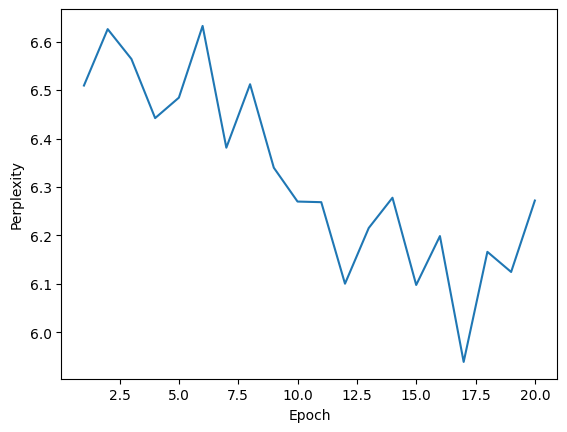

In [12]:
history_ppl_rnn = []
hist = model.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_rnn, model_name='model_rnn')], batch_size=batch_size)
show_plot(history_ppl_rnn)

Epoch 1/20
934/934 [==============================] - ETA: 0s - loss: 2.5165 - accuracy: 0.2827
 mean perplexity: 9.146696634651027 

Model saved to models/model_lstm_epoch_1.h5
Saved new model!
934/934 [==============================] - 279s 292ms/step - loss: 2.5165 - accuracy: 0.2827
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


934/934 [==============================] - ETA: 0s - loss: 2.1332 - accuracy: 0.3676
 mean perplexity: 8.011594628971803 

Model saved to models/model_lstm_epoch_2.h5
Saved new model!
934/934 [==============================] - 261s 280ms/step - loss: 2.1332 - accuracy: 0.3676
Epoch 3/20
934/934 [==============================] - ETA: 0s - loss: 2.0144 - accuracy: 0.3973
 mean perplexity: 7.416757268368927 

Model saved to models/model_lstm_epoch_3.h5
Saved new model!
934/934 [==============================] - 257s 276ms/step - loss: 2.0144 - accuracy: 0.3973
Epoch 4/20
934/934 [==============================] - ETA: 0s - loss: 1.9316 - accuracy: 0.4190
 mean perplexity: 7.034973771566893 

Model saved to models/model_lstm_epoch_4.h5
Saved new model!
934/934 [==============================] - 257s 275ms/step - loss: 1.9316 - accuracy: 0.4190
Epoch 5/20
934/934 [==============================] - ETA: 0s - loss: 1.8597 - accuracy: 0.4383
 mean perplexity: 6.670545365712227 

Model saved t

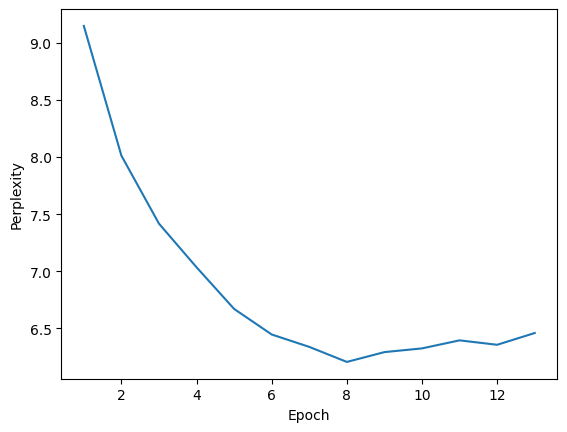

In [13]:
history_ppl_lstm = []
hist_lstm = model_lstm.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_lstm, model_name='model_lstm')], batch_size=batch_size)
show_plot(history_ppl_lstm)

Epoch 1/10
476/476 [==============================] - ETA: 0s - loss: 1.6733 - accuracy: 0.4916
 mean perplexity: 7.0907340842276225 

Model saved to models/model_gru_epoch_1.h5
Saved new model!
476/476 [==============================] - 454s 953ms/step - loss: 1.6733 - accuracy: 0.4916
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


476/476 [==============================] - ETA: 0s - loss: 1.5784 - accuracy: 0.5168
 mean perplexity: 7.365190479403708 

476/476 [==============================] - 462s 968ms/step - loss: 1.5784 - accuracy: 0.5168
Epoch 3/10
476/476 [==============================] - ETA: 0s - loss: 1.5041 - accuracy: 0.5363
 mean perplexity: 7.519433063442314 

476/476 [==============================] - 462s 971ms/step - loss: 1.5041 - accuracy: 0.5363
Epoch 4/10
476/476 [==============================] - ETA: 0s - loss: 1.4432 - accuracy: 0.5520
 mean perplexity: 7.712316925013178 

476/476 [==============================] - 459s 964ms/step - loss: 1.4432 - accuracy: 0.5520
Epoch 5/10
476/476 [==============================] - ETA: 0s - loss: 1.3930 - accuracy: 0.5650
 mean perplexity: 8.115344033118939 

476/476 [==============================] - 468s 981ms/step - loss: 1.3930 - accuracy: 0.5650
Epoch 6/10
476/476 [==============================] - ETA: 0s - loss: 1.3508 - accuracy: 0.5760
 mean p

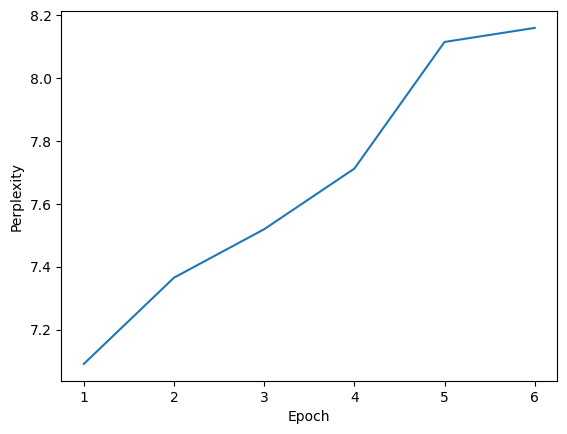

In [16]:
history_ppl_gru = []
epochs = 10
batch_size = 128
hist_gru = model_gru.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_gru, model_name='model_gru')], batch_size=batch_size)
show_plot(history_ppl_gru)


### Predicción del próximo caracter con cada modelo y cada método

In [17]:
def get_model_names(model_dir='models'):
    return [f for f in os.listdir(model_dir) if os.path.isfile(os.path.join(model_dir, f))]


In [18]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

import gradio as gr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307

In [19]:
def greedy_search_char(model, encoded, idx2char):
    y_hat = np.argmax(model.predict(encoded)[0, -1, :])
    out_word = idx2char[y_hat]
    return out_word

In [20]:
def beam_search_char(model, encoded, idx2char, beam_width=3):
    sequences = [[list(), 1.0]]
    for _ in range(len(encoded[0])):
        all_candidates = list()
        for i in range(len(sequences)):
            seq, score = sequences[i]
            predictions = model.predict(encoded)[0, -1, :]
            for j in range(len(predictions)):
                candidate = [seq + [j], score * -np.log(predictions[j])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]
    best_seq = sequences[0][0]
    out_word = ''.join([idx2char[idx] for idx in best_seq])
    return out_word


In [21]:
def model_response_char(human_text, model_name, search_method, model_dir='models'):
    # Cargar el modelo
    model = load_model(model_name, model_dir)

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower()]
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Selección del método de búsqueda
    if search_method == "greedy":
        out_word = greedy_search_char(model, encoded, idx2char)
    elif search_method == "beam":
        out_word = beam_search_char(model, encoded, idx2char)
    else:
        raise ValueError("Método de búsqueda no válido")

    # Agregar la palabra a la frase predicha
    return human_text + out_word

# Obtener la lista de modelos
model_names = get_model_names()

iface_word = gr.Interface(
    fn=model_response_char,
    inputs=[
        gr.Textbox(label="Input Text"),
        gr.Dropdown(model_names, label="Model Name"),
        gr.Dropdown(["greedy", "beam"], label="Search Method")
    ],
    outputs="text"
)

iface_word.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://4a1bb44152792e45f0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Model loaded from models/model_rnn_epoch_17.h5
1/1 [==============================] - 0s 216ms/step
Model loaded from models/model_rnn_epoch_17.h5
1/1 [==============================] - 0s 199ms/step
Model loaded from models/model_rnn_epoch_17.h5
1/1 [==============================] - 0s 224ms/step
Model loaded from models/model_rnn_epoch_17.h5


1/1 [==============================] - 0s 203ms/step
Model loaded from models/model_rnn_epoch_17.h5


1/1 [==============================] - 0s 36ms/step
Model loaded from models/model_rnn_epoch_17.h5
1/1 [==============================] - 0s 38ms/step
Model loaded from models/model_lstm_epoch_8.h5
1/1 [==============================] - 0s 432ms/step
Model loaded from models/model_lstm_epoch_8.h5
1/1 [==============================] - 1s 548ms/step
Model loaded from models/model_lstm_epoch_8.h5
1/1 [==============================] - 0s 410ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4a1bb44152792e45f0.gradio.live


### Generación de secuencias con cada modelo y con cada método

In [22]:
def get_best_model(model_dir='models'):
    model_files = [f for f in os.listdir(model_dir) if os.path.isfile(os.path.join(model_dir, f))]
    model_dict = {}
    for model_file in model_files:
        model_base_name = "_".join(model_file.split('_')[:-1])  # format 'model_epoch_{epoch_number}.h5'
        epoch_number = int(model_file.split('_')[-1].split('.')[0])
        if model_base_name not in model_dict or model_dict[model_base_name][1] < epoch_number:
            model_dict[model_base_name] = (model_file, epoch_number)
    return [model_dict[key][0] for key in model_dict]

In [23]:
def generate_seq(model, seed_text, max_length, n_words, search_method='greedy'):
    output_text = seed_text
    for _ in range(n_words):
        encoded = [char2idx[ch] for ch in output_text.lower()]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        if search_method == 'greedy':
            out_char = greedy_search_char(model, encoded, idx2char)
        elif search_method == 'beam':
            out_char = beam_search_char(model, encoded, idx2char)
        else:
            raise ValueError("Invalid search method")
        output_text += out_char
    return output_text

In [ ]:
input_text = 'orgullo'
n_words = 10
model_dir = 'models'

model_names = get_best_model(model_dir)
search_methods = ['greedy', 'beam']

for model_name in model_names:
    print(f'Model: {model_name}')
    model = load_model(model_name, model_dir)
    for search_method in search_methods:
        generated_seq = generate_seq(model, input_text, max_length=max_context_size, n_words=n_words, search_method=search_method)
        print(f'Search Method: {search_method}')
        print(f'Generated Sequence: {generated_seq}\n')


Model: model_gru_epoch_1.h5
Model loaded from models/model_gru_epoch_1.h5
1/1 [==============================] - 0s 143ms/step
Search Method: greedy
Generated Sequence: orgullo de la señ

1/1 [==============================] - 0s 56ms/step
Search Method: beam
Generated Sequence: orgullo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         